# Uncertainty quantification for cross sections
This tutorial will demonstrate how to use jitr to perform uncertainty quantification of a simple reaction observable: differential elastic scattering cross sections. We will use the uncertainty quantified optical potential KDUQ introduced here: [[Pruitt et al., 2024]](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602).

In [4]:
from pathlib import Path

import corner

# import stuff for nice plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from numba import njit
from scipy import stats
from tqdm import tqdm

We will use [exfor-tools](https://github.com/beykyle/exfor_tools) using an [x4i3](https://github.com/afedynitch/x4i3/) backend for grabbing data from [EXFOR](https://www-nds.iaea.org/exfor/) (requires 1GB of disk space to download).

In [5]:
#!pip install x4i3

In [6]:
import exfor_tools
import jitr

### Let's find some data to compare to
Let's grab some data from [EXFOR](https://www-nds.iaea.org/exfor/). We will look at $d\sigma_{el}/d\Omega$ for $(n,n)$ and $(p,p)$.

In [7]:
# targets to consider
Ca40 = (40, 20)
Ca48 = (48, 20)
Pb208 = (208, 82)

isotopes = [Ca40, Ca48, Pb208]

# for plotting differential xs
angles = np.linspace(0.1, np.pi, 100)

In [8]:
nn_entries_by_isotope = {}
pp_entries_by_isotope = {}

nn_measurements_by_isotope = {}
pp_measurements_by_isotope = {}

for isotope in isotopes:
    all_entries_pp = exfor_tools.get_exfor_differential_data(
        target=isotope,
        projectile=(1, 1),
        quantity="dXS/dA",
        product="EL",
        energy_range=[10, 100],  # MeV
    )
    pp_entries_by_isotope[isotope] = all_entries_pp
    pp_measurements_by_isotope[isotope] = exfor_tools.sort_measurements_by_energy(
        all_entries_pp
    )
    print(
        f"Found measurements at {len(list(pp_measurements_by_isotope[isotope]))} different energies for (p,p) on ({isotope[0]},{isotope[1]})"
    )

    all_entries_nn = exfor_tools.get_exfor_differential_data(
        target=isotope,
        projectile=(1, 0),
        quantity="dXS/dA",
        product="EL",
        energy_range=[10, 100],  # MeV
    )
    nn_entries_by_isotope[isotope] = all_entries_nn
    nn_measurements_by_isotope[isotope] = exfor_tools.sort_measurements_by_energy(
        all_entries_nn
    )
    print(
        f"Found measurements at {len(list(nn_measurements_by_isotope[isotope]))} different energies for (n,n) on ({isotope[0]},{isotope[1]})"
    )

Found measurements at 36 different energies for (p,p) on (40,20)
Found measurements at 11 different energies for (n,n) on (40,20)
Found measurements at 9 different energies for (p,p) on (48,20)
Found measurements at 2 different energies for (n,n) on (48,20)
There was an error reading entry C1292, it will be skipped:
Missing 'Angle' field!
There was an error reading entry O0187, it will be skipped:
Missing 'Angle' field!
There was an error reading entry O0191, it will be skipped:
Missing 'Angle' field!
Found measurements at 15 different energies for (p,p) on (208,82)
Found measurements at 17 different energies for (n,n) on (208,82)


In [9]:
def plot_exfor_data(isotope, reaction="p,p"):
    if reaction == "p,p":
        entry = pp_entries_by_isotope[isotope][
            list(pp_entries_by_isotope[isotope].keys())[0]
        ]
        measurements = pp_measurements_by_isotope[isotope]

    elif reaction == "n,n":
        entry = nn_entries_by_isotope[isotope][
            list(nn_entries_by_isotope[isotope].keys())[0]
        ]
        measurements = nn_measurements_by_isotope[isotope]

    num_measurements = len(measurements)
    max_measurements_per_plot = 12
    num_plots = num_measurements // max_measurements_per_plot
    extra = num_measurements % max_measurements_per_plot

    energies = []
    axes = []
    for i in range(num_plots):
        fig, ax = plt.subplots(1, 1, figsize=(6, 12))
        measurement_chunk = (
            measurements[
                i * max_measurements_per_plot : (i + 1) * max_measurements_per_plot
            ],
        )
        entry.plot_experiment(
            ax,
            measurement_chunk,
            offsets=50,
            label_offset_factor=2,
            label_hloc_deg=150,
            label_energy_err=False,
            label_offset=False,
        )
        energies.append([m.Ecm for m in measurement_chunk])
        axes.append(ax)
    if extra > 0:
        fig, ax = plt.subplots(1, 1, figsize=(6, 12))
        measurement_chunk = (measurements[num_plots * max_measurements_per_plot :],)
        entry.plot_experiment(
            ax,
            measurement_chunk,
            offsets=50,
            label_offset_factor=2,
            label_hloc_deg=150,
            label_energy_err=False,
            label_offset=False,
        )
        energies.append([m.Ecm for m in measurement_chunk])
        axes.append(ax)

    return axes, energies

AttributeError: 'list' object has no attribute 'units'

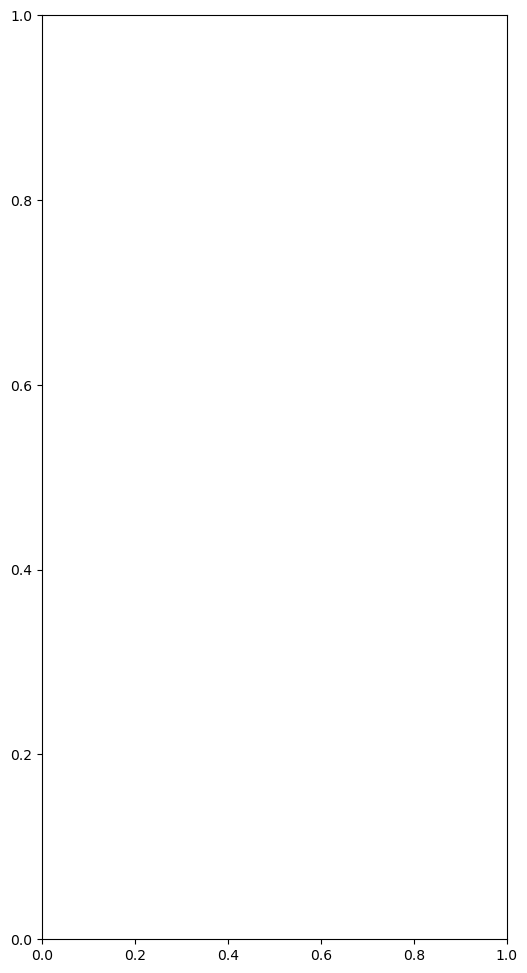

In [10]:
plot_exfor_data(Ca48)

In [ ]:
plot_exfor_data(Ca48, reaction="n,n")

In [ ]:
plot_exfor_data(Pb208, reaction="p,p")

Grabbing quasi-elastic $(p,n)$ data is a little more difficult, as EXFOR treats all $(p,n)$ data together rather than separating the data at a specific energy of the isobaric analog state. But we can pick out a few specific entries that have the data we want.

### Let's compare our data to an out-of-the-box optical model potential

We will use the the KDUQ potential from [Pruitt et al., 2024](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602) potential. The supplemental material in that link contains a set of samples from the posterior of the KDUQ parameter distribution. Let's load them up:

In [10]:
# we have 416 samples from the KDUQ posterior
num_samples_kduq = 415
param_files = [
    Path(f"./KDUQFederal/{i}/parameters.json") for i in range(0, num_samples_kduq)
]

# load each one
kduq_omps = [
    rose.koning_delaroche.KDGlobal(rose.Projectile.neutron, Path(param_file))
    for param_file in param_files
]

We will create an instance of a `rose.InteractionSpace` and a `rose.ScatteringAmplitudeEmulator` for each of these potentials, and we will use the high-fidelity solver to calculate the cross sections predicted by each model.

We will use a high-fidelity solver from the [jitr package](https://github.com/beykyle/jitr) which uses the R-Matrix method on a Lagrange-Legendre mesh.

In [11]:
core_solver = jitr.RMatrixSolver(40)

In [12]:
num_samples_pred_post = 50
kduq_pred_post = {}
kduq_solvers = {}
projectile = (1, 0)  # neutron

# for each experiment, and for each parameter sample,
# use the rose high-fidelity solver to calculate the
# KDUQ prediction
for isotope in isotopes:
    kduq_pred_post[isotope] = {}
    kduq_solvers = {}

    for measurement in nn_measurements_by_isotope[isotope]:
        Ecm = measurement.Ecm
        dEcm = measurement.dEcm

        # get kinematics and parameters for this experiment
        mu, Elab, k, eta = rose.utility.kinematics(isotope, projectile, E_com=Ecm)

        kduq = rose.InteractionSpace(
            coordinate_space_potential=rose.koning_delaroche.KD_simple,
            n_theta=rose.koning_delaroche.NUM_PARAMS,
            is_complex=True,
            spin_orbit_term=rose.koning_delaroche.KD_simple_so,
            energy=Ecm,
            mu=mu,
            k=k,
            l_max=15,
        )
        rmatrix_solver = rose.LagrangeRmatrix(
            kduq.interactions[0][0],
            np.pi * 10,
            core_solver,
        )
        kduq_solvers[Ecm] = rose.ScatteringAmplitudeEmulator.HIFI_solver(
            base_solver=rmatrix_solver,
            interaction_space=kduq,
            angles=angles,
        )

        # get a differential xs for each parameter sample
        kduq_xs = np.zeros((len(angles), num_samples_pred_post))
        samples = np.random.choice(num_samples_kduq, size=num_samples_pred_post)

        for i, sample in enumerate(tqdm(samples)):
            omp = kduq_omps[sample]
            _, params = omp.get_params(*isotope, mu, Elab, k)
            kduq_xs[:, i] = kduq_solvers[Ecm].exact_xs(params).dsdo

        # get a credible interval describing the KDUQ predictive posterior
        # for this experiment
        kduq_pred_post[isotope][str(Elab)] = (
            np.percentile(kduq_xs, 5, axis=1),
            np.percentile(kduq_xs, 95, axis=1),
        )

/home/kyle/umich/jitr/src/jitr/rmatrix.py:46: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 1, 'C', False, aligned=True), Array(complex128, 2, 'A', False, aligned=True))
  R, Ainv = rmatrix_with_inverse(A, b, nchannels, nbasis, a)
/home/kyle/umich/rose/src/rose/koning_delaroche.py:450: RuntimeWarning: overflow encountered in exp
  d2 = self.d2_0 + self.d2_A / (1 + np.exp((A - self.d2_A3) / self.d2_A2))


Now that we have our model predictions, lets plot them compared to the experimental data. We will offset each energy for visibility.

ValueError: 'yerr' must not contain negative values

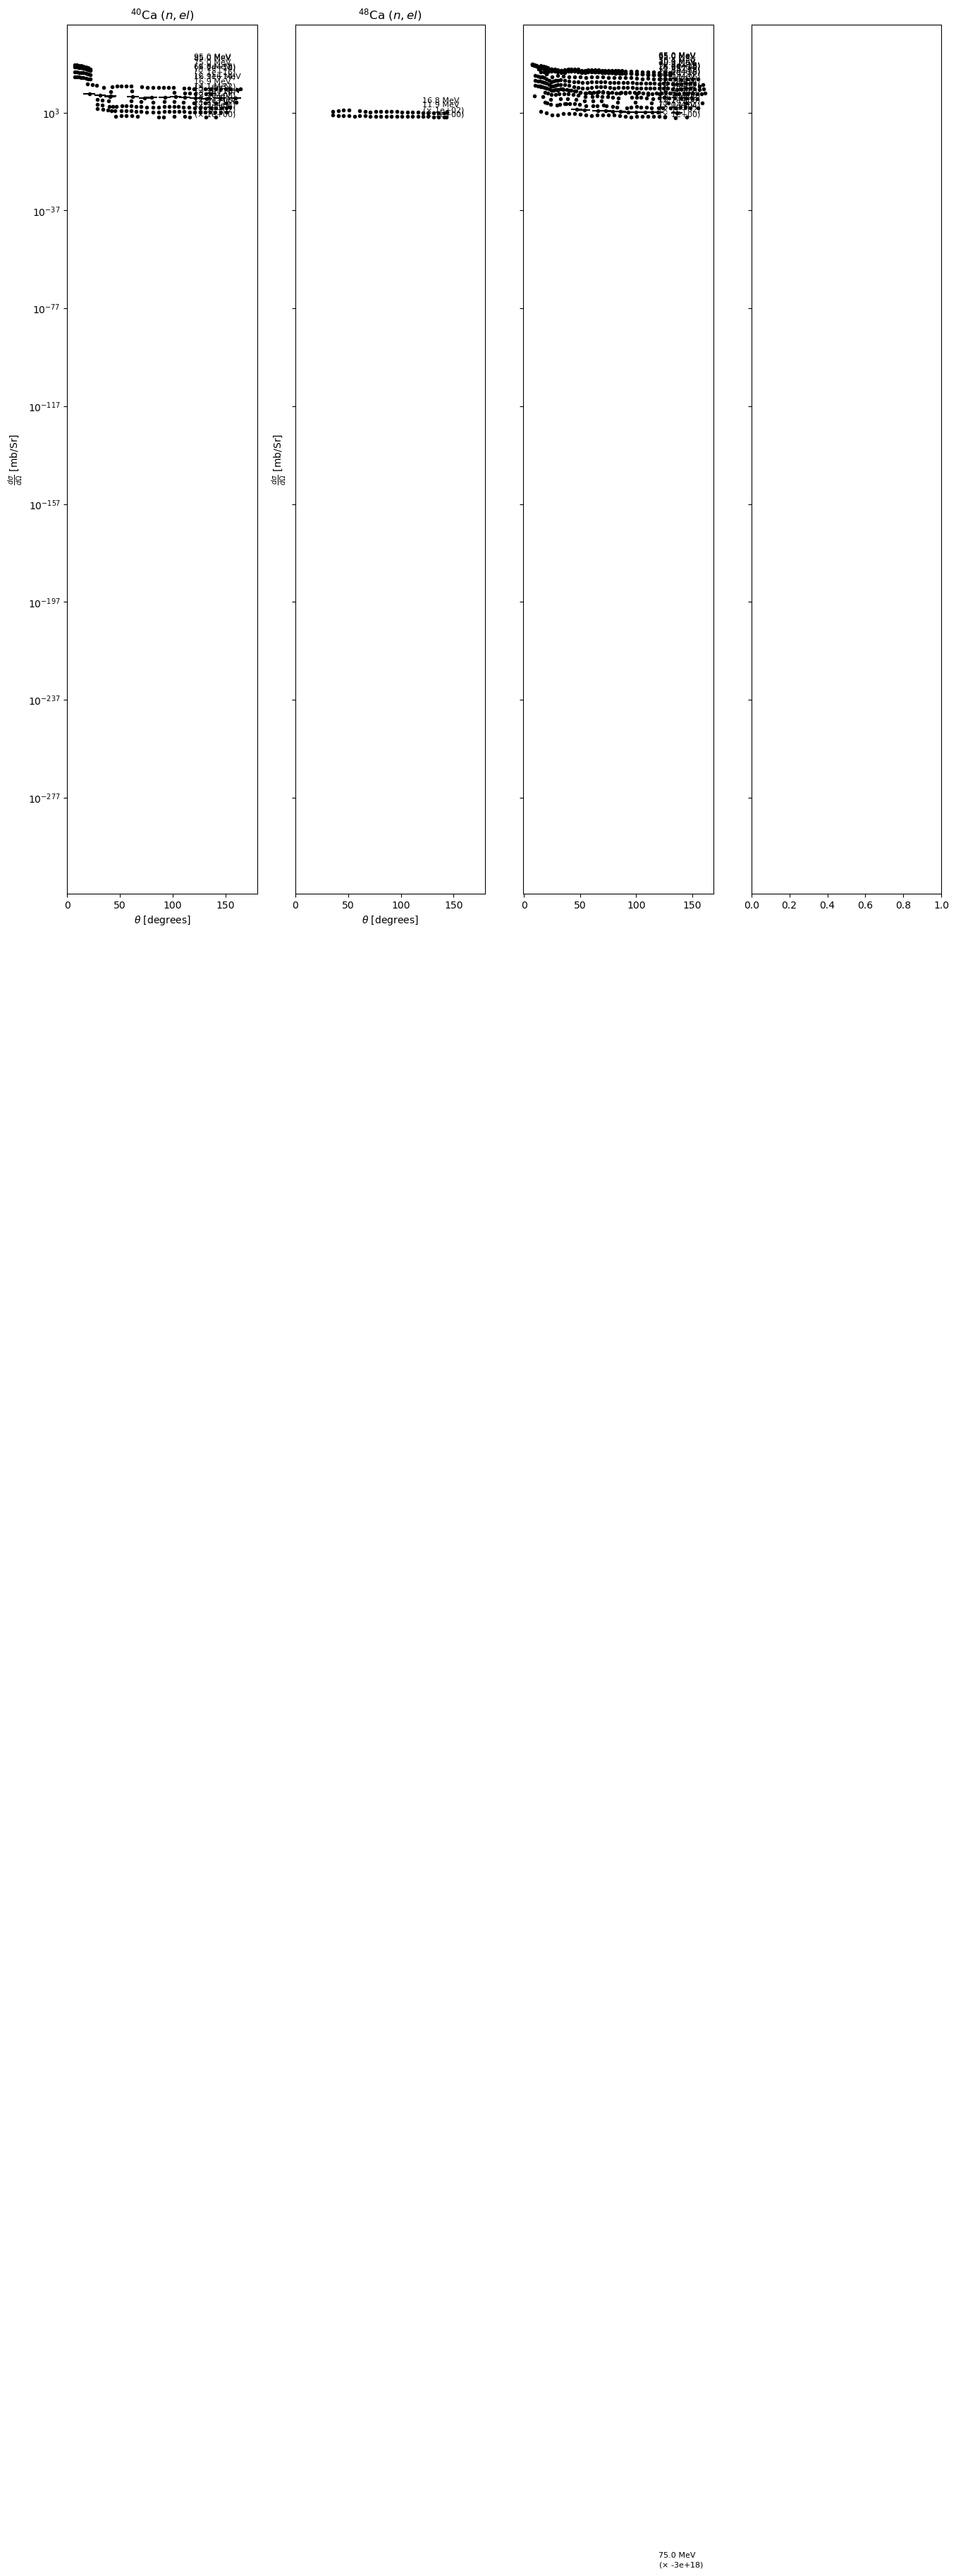

In [19]:
fig, axes = plt.subplots(1, len(isotopes), figsize=(3 * len(isotopes), 16), sharey=True)
for isotope, ax in zip(isotopes, axes):
    offset = 1
    an_entry = nn_entries_by_isotope[isotope]

    for entry in data_by_isotope[isotope]:
        for i, (Elab, dElab) in enumerate(entry.energies):
            # plot experiment
            x, y, dy = (
                entry.measurements[i][:, 0],
                entry.measurements[i][:, 1],
                entry.measurements[i][:, 2],
            )
        ax.errorbar(
            x,
            offset * y,
            offset * dy,
            marker="o",
            alpha=0.8,
            linestyle="none",
            color="k",
        )

        # plot model
        ax.fill_between(
            angles * 180 / np.pi,
            offset * kduq_pred_post[isotope][str(Elab)][0],
            offset * kduq_pred_post[isotope][str(Elab)][1],
            color=kd_color,
            alpha=0.5,
        )

        # add a label
        energy = str(Elab)
        label_loc = (145, offset * np.min(y) / 2)
        ax.text(*label_loc, f"{energy} MeV")

        offset *= 100

leg_models = [
    Line2D([0], [0], color=kd_color, label=r"KDUQ $95\%$ credible interval", alpha=0.2),
]
leg1 = ax1.legend(handles=leg_models, loc="upper right")
ax1.add_artist(leg1)


# plt.ylim([1, 1e6])
plt.yscale("log")
ax1.set_ylabel(r"$d\sigma/d\Omega$ [%s]" % entry.units[1])
ax1.legend()

Turns out KDUQ isn't bad, but some of the data points are definitely outside of the 95% credible interval. Addtionally, for some of those points, there is negligible experimental data. In particular, the first big diffraction peak in the $^{48}$Ca @ 11.9 MeV data set and the large angles of the $^{48}$Ca @ 11.9 and 7.97 MeV sets seem to have statistically significant disagreement between model and experiment. What could be going on here?

Let's see how we do with our simple EL model. But first, running the high-fidelity solver in rose 50 times for each of the 5 experiments took a few minutes. Doing a full calibration may require hundreds of thousands of parameter samples. We need to build an emulator! But first, let's specify a prior for our EL model.

## Specifying the Prior

We need a prior distribution of the parameters that go into our EL model. For the sake of simplicity, we will just guestimate this prior by looking at KDUQ (see Table V. in [Pruitt et al., 2024](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602)) as well as the original Koning-Delaroche local parameterization for $^{40}$Ca [Koning et al., 2003](https://www.sciencedirect.com/science/article/pii/S0375947402013210) Tables 3 and 4. We will assume our prior can be described by inividual beta functions without correlations.

In [ ]:
# grab KDUQ params for Ca40 at 14.1 MeV, a roughly representative energy
# for our region of interest
mu, E_com, k, eta = rose.utility.kinematics(Ca48, (1, 0), E_lab=14.1)
ca48_mean_params = np.mean(
    [op.get_params(*Ca48, mu, E_lab, k)[1] for op in kduq_omps], axis=0
)
ca48_std_params = np.std(
    [op.get_params(*Ca48, mu, E_lab, k)[1] for op in kduq_omps], axis=0
)

In [ ]:
# grab KDUQ params for Ca48 in same ROI
mu, E_com, k, eta = rose.utility.kinematics(Ca40, (1, 0), E_lab=14.1)
ca40_mean_params = np.mean(
    [op.get_params(*Ca40, mu, E_lab, k)[1] for op in kduq_omps], axis=0
)
ca40_std_params = np.std(
    [op.get_params(*Ca40, mu, E_lab, k)[1] for op in kduq_omps], axis=0
)

In [ ]:
# look at the KDUQ isoscalar params averaged b/t Ca40 and 48
for i in range(15):
    print(
        i,
        ca40_mean_params[i],
        ca48_mean_params[i],
    )

In [ ]:
# look at the KDUQ isoscalar params averaged b/t Ca40 and 48
for i in range(15):
    print(
        i,
        (ca40_mean_params[i] + ca48_mean_params[i]) / 2,
        (ca40_std_params[i] + ca48_std_params[i]) / 2,
    )

In [ ]:
# look at the KDUQ isovector params within the Ca chain
asym = 8.0 / 40
for i in range(15):
    print(
        i,
        (ca40_mean_params[i] - ca48_mean_params[i]) / asym,
        (ca40_std_params[i] - ca48_std_params[i]) / asym,
    )

In [ ]:
# just guestimate based on KDUQ
# notice the relative uncertainties are quite large in some cases
# we will go ahead and inflate the std deviation of the isovector terms compared to
# the KDUQ prior
#                V      W    WD   Vso  V1    Wd1   r0     rA     a
mean = np.array([47, 1.55, 6.0, 4.89, 10.0, 3.5, 0.0, 1.2, 0.678])
stdev = np.array([5.0, 2.0, 1.0, 0.9, 2.0, 1.0, 0.3, 0.3, 0.05])

In [ ]:
n_stds = 1
feasibility_bounds = np.array([mean - n_stds * stdev, mean + n_stds * stdev]).T

In [ ]:
prior_volume = np.prod(feasibility_bounds[1, :] - feasibility_bounds[0, :])

In [ ]:
# scale and shift each param to [-1,1]
def transform(x):
    return (x - mean) / stdev


def reverse(y):
    return y * stdev + mean

### scale and shift parameters

In [ ]:
def log_prior_transformed(x):
    if np.all(x >= -1) and np.all(x < 1):
        return (1 / 2) ** elm_num_sub_params
    else:
        return -np.inf

In [ ]:
prior_samples = rose.training.latin_hypercube_sample(3000, feasibility_bounds)
prior_transformed = transform(prior_samples)

## Visualize the shape of the potentials

let's compare the general shape of KDUQ and ELM as a visual sanity check that our prior is reasonable.

In [ ]:
r = np.linspace(0, 10, 100)
E = 14.1
isotope = Ca48
l_dot_s = 0
mu, E_com, k, eta = rose.utility.kinematics(isotope, (1, 0), E_lab=E)


def get_potential_intervals(u, interval=95):
    x = 100 - interval
    return (
        np.percentile(u.real, x, axis=1) + 1j * np.percentile(u.imag, x, axis=1),
        np.percentile(u.real, interval, axis=1)
        + 1j * np.percentile(u.imag, interval, axis=1),
    )


elm_pot_params = [el_model_params(*isotope, *sample) for sample in prior_samples]
elm_potentials = np.array(
    [el_model_simple(r, p) + el_model_simple_so(r, p, l_dot_s) for p in elm_pot_params]
).T

kduq_pot_params = [op.get_params(*isotope, mu, E, k)[1] for op in kduq_omps]
kduq_potentials = np.array(
    [
        rose.koning_delaroche.KD_simple(r, p)
        + rose.koning_delaroche.KD_simple_so(r, p, l_dot_s)
        for p in kduq_pot_params
    ]
).T

kduq_potential_intervals = get_potential_intervals(kduq_potentials)
elm_potential_prior_intervals = get_potential_intervals(elm_potentials)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.fill_between(
    r,
    elm_potential_prior_intervals[0].real,
    elm_potential_prior_intervals[1].real,
    alpha=0.5,
    color=elm_color,
    label="ELM $95\%$ prior interval",
)
ax1.fill_between(
    r,
    kduq_potential_intervals[0].real,
    kduq_potential_intervals[1].real,
    alpha=0.5,
    color=kd_color,
    label="KDUQ $95\%$ posterior interval",
)
ax2.fill_between(
    r,
    elm_potential_prior_intervals[0].imag,
    elm_potential_prior_intervals[1].imag,
    alpha=0.5,
    color=elm_color,
)
ax2.fill_between(
    r,
    kduq_potential_intervals[0].imag,
    kduq_potential_intervals[1].imag,
    alpha=0.5,
    color=kd_color,
)
ax1.set_xlabel(r"$r$ [fm]", fontsize=14)
ax2.set_xlabel(r"$r$ [fm]", fontsize=14)
ax1.legend(loc="upper left", fontsize=14)
ax1.set_ylabel(r"$\mathfrak{Re}\, U(r)$ [MeV]", fontsize=14)
ax2.set_ylabel(r"$\mathfrak{Im}\, U(r)$ [MeV]", fontsize=14)
plt.tight_layout()

Nice! This seems like a reasonable place to start the calibration. We can use these samples to initiate our MCMC walkers. But first, let's build an emulator.

## Training a rose emulator
To make this calibration doable on your laptop, we will use a reduced basis method emulator called [`rose`](github.com/bandframework/rose). For the theory behind it, see:
- https://dr.ascsn.net/landing.html
- https://journals.aps.org/prc/abstract/10.1103/PhysRevC.109.044612

The software is open source and lives here: https://github.com/bandframework/rose

The easiest way to go about this will be to emulate across the parameters in `el_model_simple`, rather than subparameters that we actually want to do a statistical calibration for. Let's convert our prior of sub-parameters into the parameters we want to emulate across, so we can determine the region of interest on which to train our emulator.

In [ ]:
s_max = np.pi * 10
mesh_size = 400
s_mesh = np.linspace(0.02, s_max, mesh_size)

# what fraction of variance in the training set should we describe?
# this determines how many basis elements to use in the reduced basis
max_fraction_unexplained_variance = 0.5e-7

In [ ]:
%%time
emulators = {}
roi_bounds = {}

for A in data.keys():
    isotope = isotopes[A]
    emulators[A] = {}
    roi_bounds[A] = {}
    for experiment in data[A].keys():
        x, y, dy = (
            data[A][experiment][:, 0],
            data[A][experiment][:, 1],
            data[A][experiment][:, 2],
        )
        # what energy was this experiment performed at?
        E_lab = energies[A][experiment]

        # get kinematics and parameters for this experiment
        mu, E_com, k, _ = rose.utility.kinematics(isotope, (1, 0), E_lab=E_lab)

        # get prior distribution of main params for given isotope
        prior_roi_samples = np.array(
            [el_model_params(*isotope, *sample) for sample in prior_samples]
        )

        # find bounds of this ROI (region of interest)
        roi_bounds[A][experiment] = np.array(
            [
                np.min(prior_roi_samples, axis=0) * 0.5,
                np.max(prior_roi_samples, axis=0) * 1.5,
            ]
        ).T

        # sample some training parameters using Latin Hypercube to get all corners
        # of our ROI
        train = rose.utility.latin_hypercube_sample(
            100, bounds=roi_bounds[A][experiment], seed=132
        )

        # set up the rose interaction space for emulation
        elm_interaction = rose.InteractionEIMSpace(
            coordinate_space_potential=el_model_simple,
            spin_orbit_term=el_model_simple_so,
            n_theta=elm_num_params,
            is_complex=True,
            expl_var_ratio_cutoff=max_fraction_unexplained_variance,
            rho_mesh=s_mesh,
            training_info=roi_bounds[A][experiment],
            l_max=15,
            mu=mu,
            energy=E_com,
            k=k,
        )

        # set up high-fidelity solver for training and testing the emulator
        rmatrix_solver = rose.LagrangeRmatrix(
            elm_interaction.interactions[0][0], s_0=s_max, solver=jitr.RMatrixSolver(50)
        )

        # train the emulator
        emulators[A][experiment] = rose.ScatteringAmplitudeEmulator.from_train(
            interaction_space=elm_interaction,
            base_solver=rmatrix_solver,
            alpha_train=train,
            s_mesh=s_mesh,
            expl_var_ratio_cutoff=max_fraction_unexplained_variance,
            angles=x * np.pi / 180,
        )

## Testing the emulator
Nice! We have a trained emulator. But we should make sure it actually works. Fortunately, `rose` is set up with a bit of a cheat code for this: because it is a projective method, it will work so long as the basis it projects onto sufficiently describes the high-fidelity description. A good metric for this is how many basis elements we kept - if it's a reasonably small number, than we have done a good job in reducing the dimensions!

In [ ]:
# let's check one of the emulators
swave_basis = emulators[40]["Mueller_169"].rbes[0][0].basis
sv_sqr_kept = np.sum(swave_basis.singular_values[: swave_basis.n_basis] ** 2)
sv_sqr_all = np.sum(swave_basis.singular_values**2)
explained_variance = sv_sqr_kept / sv_sqr_all
print(
    f"The S-wave channel required {swave_basis.n_basis} "
    f"basis elements to describe all but {(1.0 - explained_variance)*100:1.6e}% "
    "of the variance in the training set."
)

A more thorough way to test is to compare high-fidelity and emulated observables for a set of test samples not on the training set:

In [ ]:
test = rose.utility.latin_hypercube_sample(
    20, bounds=roi_bounds[40]["Mueller_169"], seed=61
)

In [ ]:
%%time
# run high-fidelity solver
HIFI_xs = []
for sample in tqdm(test):
    HIFI_xs.append(emulators[40]["Mueller_169"].exact_xs(sample, angles=angles))

In [ ]:
%%time
# run emulator
emu_xs = []
for sample in tqdm(test):
    emu_xs.append(emulators[40]["Mueller_169"].emulate_xs(sample, angles=angles))

In [ ]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor("white")

for i, sample in enumerate(test[::2]):
    x = angles * 180 / np.pi

    # HIFI
    y_exact = HIFI_xs[i].dsdo

    # emulated
    y_emu = emu_xs[i].dsdo

    p = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)


legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["RBM", "Runge-Kutta"])
ax.set_yscale("log")
plt.xlabel(r"$\theta$ [radians]", fontsize=12)
plt.ylabel(r"$d \sigma / d \Omega$ ", fontsize=12)

In real life, we should really do some more thorough convergence testing to make sure our emulator is robust, and characterize its relative error!

## Visualizing the cross sections predicted by the prior 

Let's look at how well our prior compares to KDUQ. It is based on KDUQ, so it should be similar.

In [ ]:
elm_prior = {}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
for A, ax in zip(data.keys(), [ax1, ax2]):
    offset = 1
    ax.set_title(r"$^{%d}$Ca $(n,n)$" % A)
    ax.set_xlabel(r"$\theta$ [deg]")
    ax.set_xlim([0, 190])
    elm_prior[A] = {}
    for experiment in data[A].keys():
        # plot experiment
        x, y, dy = (
            data[A][experiment][:, 0],
            data[A][experiment][:, 1],
            data[A][experiment][:, 2],
        )
        ax.errorbar(
            x,
            offset * y,
            offset * dy,
            marker="o",
            alpha=0.8,
            linestyle="none",
            color="k",
        )

        # plot KDUQ
        ax.fill_between(
            angles * 180 / np.pi,
            offset * kduq_pred_post[A][experiment][0],
            offset * kduq_pred_post[A][experiment][1],
            color=kd_color,
            alpha=0.5,
        )

        # evaluate ELM
        N_samples = 500
        xs = np.zeros((len(angles), N_samples))
        total_N = len(prior_samples)
        for i in tqdm(range(N_samples)):
            params = el_model_params(*isotope, *prior_samples[i, :])
            xs[:, i] = emulators[A][experiment].exact_xs(params, angles=angles).dsdo

        # get a credible interval describing the ELM predictive posterior
        # for this experiment
        elm_prior[A][experiment] = (
            np.percentile(xs, 5, axis=1),
            np.percentile(xs, 95, axis=1),
        )

        # plot ELM
        ax.fill_between(
            angles * 180 / np.pi,
            offset * elm_prior[A][experiment][0],
            offset * elm_prior[A][experiment][1],
            color=elm_color,
            alpha=0.5,
        )

        # add a label
        energy = energies[A][experiment]
        label_loc = (145, offset * np.min(y) / 2)
        ax.text(*label_loc, f"{energy} MeV")

        offset *= 20

leg_models = [
    Line2D([0], [0], color=kd_color, label=r"KDUQ $95\%$ credible interval", alpha=0.5),
    Line2D(
        [0],
        [0],
        color=elm_color,
        label=r"ELM prior $95\%$ credible interval",
        alpha=0.5,
    ),
]
leg1 = ax1.legend(handles=leg_models, loc="upper right")
ax1.add_artist(leg1)


plt.ylim([1, 1e6])
plt.yscale("log")
ax1.set_ylabel(r"$d\sigma/d\Omega$")
ax1.legend()

We should see that our prior is quite uninformative, but it does generally encompass the experimental data. Lets tighten up those bands by calibrating our model!

## Building a statistical model

In [ ]:
emulator_err = 0.05
model_err = 0.05


def log_likelihood(x):
    subparams = reverse(x)
    log_likelihood = 0
    for A in data.keys():
        isotope = isotopes[A]
        params = el_model_params(*isotope, *subparams)
        for experiment in data[A].keys():
            x, y, dy = (
                data[A][experiment][:, 0],
                data[A][experiment][:, 1],
                data[A][experiment][:, 2],
            )
            y_model = emulators[A][experiment].exact_xs(params).dsdo
            # y_model = emulators[A][experiment].emulate_xs(params).dsdo
            residual = (y - y_model) ** 2
            log_likelihood -= 0.5 * np.sum(
                residual / (dy + emulator_err * y_model + model_err * y_model) ** 2
            )
    return log_likelihood

In [ ]:
def log_prior(x):
    return log_prior_transformed(x)

In [ ]:
def log_posterior(x):
    return log_likelihood(x) + log_prior(x)

## Performing the calibration

In [ ]:
# I'm walkin here
n_walkers = 10
n_accepted = np.zeros(n_walkers)
n_iter = 3000
n_burn = 500

# place to put samples
mcmc_samples = np.zeros((n_walkers, n_iter - n_burn, elm_num_sub_params))

# proposal distribution
step_sizes0 = 0.1 * np.ones(elm_num_sub_params)
step_distribution_mean = np.zeros(elm_num_sub_params)
step_distribution_cov = np.zeros((elm_num_sub_params, elm_num_sub_params))
step_distribution_cov += np.diag(step_sizes0) ** 2

In [ ]:
%%time
log_post = np.zeros((n_walkers, n_iter - n_burn))
for i in tqdm(range(n_walkers)):
    # start walker by grabbing a sample from the prior
    sample = prior_transformed[i]

    # walk until you get tired
    for j in range(n_iter):
        next_sample = sample + np.random.multivariate_normal(
            step_distribution_mean, step_distribution_cov
        )
        lp = log_posterior(sample)
        nlp = log_posterior(next_sample)
        log_post[i][j - n_burn] = lp

        acceptance_prob = np.exp(lp - nlp)

        if j >= n_burn:
            if np.random.rand() > acceptance_prob:
                sample = next_sample
                n_accepted[i] += 1

            mcmc_samples[i, j - n_burn, :] = sample

In [ ]:
acceptance_ratios = n_accepted / (n_iter - n_burn)
print(f"Acceptance ratios (should be around 1/3): {acceptance_ratios}")

In [ ]:
samples_per_walker = n_iter - n_burn
mcmc_samples = reverse(mcmc_samples)
posterior_samples = mcmc_samples.reshape(
    (n_walkers * samples_per_walker, elm_num_sub_params)
)
posterior_samples.shape

In [ ]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
fig, axs = plt.subplots(elm_num_sub_params + 1, 1, figsize=(12, 24), sharex="all")

# plot samples
for i in range(elm_num_sub_params):
    axs[i].axhline(y=mean[i], color="r")
    axs[i].set_ylabel(elm_param_labels[i], fontsize=18)

    for j in range(n_walkers):
        axs[i].plot(mcmc_samples[j, :, i], alpha=0.65)

# plot log posteripor
for i in range(n_walkers):
    axs[-1].plot(log_post[i, :])
    axs[-1].set_ylabel(r"$\log{ p(y | \alpha)}$", fontsize=18)

plt.xlabel("step", fontsize=14)
plt.tight_layout()
plt.show()

## Plotting the results

In [ ]:
fig = corner.corner(
    posterior_samples,
    labels=list(elm_param_labels),
    show_titles=True,
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16},
)
corner.corner(prior_samples, fig=fig, color="red")
fig.tight_layout()

In [ ]:
elm_pred_post = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
for A, ax in zip(data.keys(), [ax1, ax2]):
    offset = 1
    ax.set_title(r"$^{%d}$Ca $(n,n)$" % A)
    ax.set_xlabel(r"$\theta$ [deg]")
    ax.set_xlim([0, 190])
    elm_pred_post[A] = {}

    for experiment in data[A].keys():
        # plot experiment
        x, y, dy = (
            data[A][experiment][:, 0],
            data[A][experiment][:, 1],
            data[A][experiment][:, 2],
        )
        ax.errorbar(
            x,
            offset * y,
            offset * dy,
            marker="o",
            alpha=0.8,
            linestyle="none",
            color="k",
        )

        # plot KDUQ
        ax.fill_between(
            angles * 180 / np.pi,
            offset * kduq_pred_post[A][experiment][0],
            offset * kduq_pred_post[A][experiment][1],
            color=kd_color,
            alpha=0.5,
        )

        # evaluate ELM
        N_samples = 300
        xs = np.zeros((len(angles), N_samples))
        sample_idxs = np.random.choice(len(posterior_samples), N_samples)
        for i in tqdm(range(N_samples)):
            params = el_model_params(*isotope, *posterior_samples[sample_idxs[i], :])
            xs[:, i] = emulators[A][experiment].emulate_xs(params, angles=angles).dsdo

        # get a credible interval describing the ELM predictive posterior
        # for this experiment
        elm_pred_post[A][experiment] = (
            np.percentile(xs, 5, axis=1),
            np.percentile(xs, 95, axis=1),
        )

        # plot ELM
        ax.fill_between(
            angles * 180 / np.pi,
            offset * elm_pred_post[A][experiment][0],
            offset * elm_pred_post[A][experiment][1],
            color=elm_color,
            alpha=0.5,
        )

        # add a label
        energy = energies[A][experiment]
        label_loc = (145, offset * np.min(y) / 2)
        ax.text(*label_loc, f"{energy} MeV")

        offset *= 20

leg_models = [
    Line2D([0], [0], color=kd_color, label=r"KDUQ $95\%$ credible interval"),
    Line2D([0], [0], color=elm_color, label=r"ELM $95\%$ credible interval"),
]
leg1 = ax1.legend(handles=leg_models, loc="upper right")
ax1.add_artist(leg1)

plt.ylim([1, 1e6])
plt.yscale("log")
ax1.set_ylabel(r"$d\sigma/d\Omega$")
ax1.legend()

## Generate a predictive posterior for $^{60}$Ca and $^{70}$Ca!

In [ ]:
# we'll probably never have experimental data for 70Ca(n,n) but let's pretend
Ca70 = (70, 20)
Ca60 = (60, 20)
energy = 10